In [1]:
#https://github.com/XifengGuo/DCEC/blob/master/DCEC.py
from time import time
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from sklearn.cluster import KMeans
from datasets import load_mnist, load_usps, load_mrec


In [2]:
import metrics
from ConvAE import CAE
yHid=None


In [3]:
def printMetrics(aName,yy,_loss):
        if yHid is not None:
                    acc = np.round(metrics.acc(yHid, yy), 5)
                    nmi = np.round(metrics.nmi(yHid, yy), 5)
                    ari = np.round(metrics.ari(yHid, yy), 5)
                    loss = np.round(_loss, 7)
                    #logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, L=_loss[0], Lc=_loss[1], Lr=_loss[2])
                    #logwriter.writerow(logdict)
                    # print('Iter', ite, ': Acc', acc, ', nmi', nmi, ', ari', ari, '; loss=', loss,'  delta=',delta_label)

                    print(aName,'acc = %.4f, nmi = %.4f, ari = %.4f' % (acc,nmi,ari),';  loss=',_loss)


In [4]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

 

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight('clusters',(self.n_clusters, input_dim), initializer='glorot_uniform')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    

In [5]:
class DCEC(object):
    def __init__(self,
                 input_shape,
                 filters=[32, 64, 128, 10],
                 n_clusters=10,
                 alpha=1.0):

        super(DCEC, self).__init__()

        self.n_clusters = n_clusters
        self.input_shape = input_shape
        self.alpha = alpha
        self.pretrained = False
        self.y_pred = []
        self.delata_label = 0 
        self.save_dir='temp'
        self.yHid=None

        self.cae = CAE(input_shape, filters)
        hidden = self.cae.get_layer(name='embedding').output
        self.encoder = Model(inputs=self.cae.input, outputs=hidden)

        # Define DCEC model
        print('nn',self.n_clusters)
        clustering_layer = ClusteringLayer(n_clusters=self.n_clusters, name='clustering')(hidden)
        self.model = Model(inputs=self.cae.input,
                           outputs=[clustering_layer, self.cae.output])

    def pretrain(self, x, batch_size=256, epochs=50, optimizer='adam'):
        print('...Pretraining...')
        self.cae.compile(optimizer=optimizer, loss='mse')
        from tensorflow.keras.callbacks import CSVLogger
        csv_logger = CSVLogger(self.save_dir + '/pretrain_log.csv')

        # begin training
        t0 = time()
        self.cae.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=[csv_logger])
        print('Pretraining time: ', time() - t0)
        self.cae.save(self.save_dir + '/pretrain_cae_model.h5')
        print('Pretrained weights are saved to %s/pretrain_cae_model.h5' % self.save_dir)
        self.pretrained = True

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def extract_feature(self, x):  # extract features from before clustering layer
        return self.encoder.predict(x)

    def predict(self, x):
        q, _ = self.model.predict(x, verbose=0)
        return q.argmax(1)
    

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, loss=['kld', 'mse'], loss_weights=[1, 1], optimizer='adam'):
        self.model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer)

    def dopretrain(self,x, cae_weights=None,batch_size=256,epochs=50):
        # Step 1: pretrain if necessary
        if not self.pretrained or (cae_weights is None):
            #Nepoch=50
            print('...pretraining CAE using default hyper-parameters:')
            print('   optimizer=\'adam\';   epochs=',epochs)
            self.pretrain(x, batch_size, epochs=epochs)
            self.cae.save_weights( 'pretrain_cae.h5')
      
            self.pretrained = True
        elif cae_weights is not None:
            self.cae.load_weights('pretrain_cae.h5')
            print('cae_weights is loaded successfully.')
  
    def fit(self, x, batch_size=256, maxiter=2e3, tol=1e-2,
            update_interval=140, save_dir='temp'):

        print('Update interval', update_interval)
        save_interval=update_interval*2 
        #save_interval = int(x.shape[0] / batch_size * 10)
        print('Save interval', save_interval)

   
        # Step 2: initialize cluster centers using k-means
        #t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        self.y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(self.y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
        loss = [0, 0, 0]
 
        printMetrics("kMeans",self.y_pred,loss)    
        # Step 3: deep clustering
        # logging file
        import csv, os
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        logfile = open(self.save_dir + '/dcec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'L', 'Lc', 'Lr'])
        logwriter.writeheader()

        index = 0
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q, _ = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                self.y_pred = q.argmax(1)
                # check stop criterion
                delta_label = np.sum(self.y_pred != y_pred_last).astype(np.float32) / self.y_pred.shape[0]
                printMetrics('Iter '+ str(ite),self.y_pred,loss)
             
                # check stop criterion
                #delta_label = np.sum(self.y_pred != y_pred_last).astype(np.float32) / self.y_pred.shape[0]
                y_pred_last = np.copy(self.y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    #logfile.close()
                    break

            # train on batch
            if (index + 1) * batch_size > x.shape[0]:
                loss = self.model.train_on_batch(x=x[index * batch_size::],
                                                 y=[p[index * batch_size::], x[index * batch_size::]])
                index = 0
            else:
                loss = self.model.train_on_batch(x=x[index * batch_size:(index + 1) * batch_size],
                                                 y=[p[index * batch_size:(index + 1) * batch_size],
                                                    x[index * batch_size:(index + 1) * batch_size]])
                index += 1

            # save intermediate model
            if ite % save_interval == 0:
                # save DCEC model checkpoints
                print('saving model to:', save_dir + '/dcec_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/dcec_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/dcec_model_final.h5')
        self.model.save_weights(save_dir + '/dcec_model_final.h5')
        #t3 = time()
 

In [6]:
# load dataset
Ndataset='mrec'
Nclusters=10
Nsave_dir='temp'
Ngamma=0.1
Ntol=0.001

In [7]:
ddd=[1,2,4]
np.savetxt(fname="saved.csv", delimiter=",", X=ddd)

#ddd.savetxt('mnisttxt')

In [8]:
#clusteringll = ClusteringLayer(10, name='clustering')(hidden)
#from tensorflow.keras.datasets import mnist
#(x_t, y_t), (x_s, y_s) = mnist.load_data()
#xtt = x_t.reshape(-1, 784).astype('int32')

#np.savetxt(fname="saved-rain-fall-row-col-names.csv", delimiter=",", X=xtt)

#x_t.savetxt('mnisttxt')

In [9]:
from datasets import load_mnist, load_usps, load_mrec
if Ndataset == 'mnist':
    x, yHid = load_mnist()
elif Ndataset == 'usps':
    x, yHid = load_usps('data/usps')
elif Ndataset == 'mrec':
    x, YY = load_mrec()
elif Ndataset == 'mnist-test':
    x, yHid = load_mnist()
    x, yHid = x[60000:], yHid[60000:]

MM (4032, 1026)
MREC: (4031, 16, 16, 1)


In [10]:
# prepare the DCEC model
dcec = DCEC(input_shape=x.shape[1:], filters=[32, 64, 128, 10], n_clusters=Nclusters)
#plot_model(dcec.model, to_file=Nsave_dir + '/dcec_model.png', show_shapes=True)
dcec.model.summary()
dcec.save_dir=Nsave_dir
dcec.yHid=yHid


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 8, 8, 32)          832       
_________________________________________________________________
conv2 (Conv2D)               (None, 4, 4, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
embedding (Dense)            (None, 10)                5130      
_________________________________________________________________
dense (Dense)                (None, 512)               5632      
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 128)         0

In [11]:
optimizer = 'adam'
Ntol=0.001
Ngamma=0.2
    

In [12]:
dcec.compile(loss=['kld', 'mse'], loss_weights=[Ngamma, 1], optimizer=optimizer)
t0 = time() 
dcec.dopretrain(x,cae_weights=None,batch_size=256,epochs=60)
#dcec.dopretrain(x,cae_weights=1,batch_size=256,epochs=30)
t1 = time()


...pretraining CAE using default hyper-parameters:
   optimizer='adam';   epochs= 60
...Pretraining...
Epoch 1/60
4031/4031 [==============================] - 1s 145us/sample - loss: 0.0748
Epoch 2/60
4031/4031 [==============================] - 0s 108us/sample - loss: 0.0555
Epoch 3/60
4031/4031 [==============================] - 0s 110us/sample - loss: 0.0347
Epoch 4/60
4031/4031 [==============================] - 0s 111us/sample - loss: 0.0177
Epoch 5/60
4031/4031 [==============================] - 0s 109us/sample - loss: 0.0105
Epoch 6/60
4031/4031 [==============================] - 0s 109us/sample - loss: 0.0079
Epoch 7/60
4031/4031 [==============================] - 0s 109us/sample - loss: 0.0063
Epoch 8/60
4031/4031 [==============================] - 0s 109us/sample - loss: 0.0053
Epoch 9/60
4031/4031 [==============================] - 0s 109us/sample - loss: 0.0046
Epoch 10/60
4031/4031 [==============================] - 0s 109us/sample - loss: 0.0041
Epoch 11/60
4031/4031 [===

In [13]:
t10 = time()
dcec.fit(x,  tol=Ntol, maxiter=2e3,
             update_interval=140)
y_pred = dcec.y_pred
t11 = time()

printMetrics('end:',y_pred,[0])
#print('acc = %.4f, nmi = %.4f, ari = %.4f' % (metrics.acc(y, y_pred), metrics.nmi(y, y_pred), metrics.ari(y, y_pred)))

Update interval 140
Save interval 280
Initializing cluster centers with k-means.
saving model to: temp/dcec_model_0.h5
saving model to: temp/dcec_model_280.h5
saving model to: temp/dcec_model_560.h5
saving model to: temp/dcec_model_840.h5
saving model to: temp/dcec_model_1120.h5
saving model to: temp/dcec_model_1400.h5
saving model to: temp/dcec_model_1680.h5
delta_label  0.0009923096005953857 < tol  0.001
Reached tolerance threshold. Stopping training.
saving model to: temp/dcec_model_final.h5


In [14]:
np.savetxt(fname="ypred.csv",fmt="%d", delimiter=",", X=y_pred)


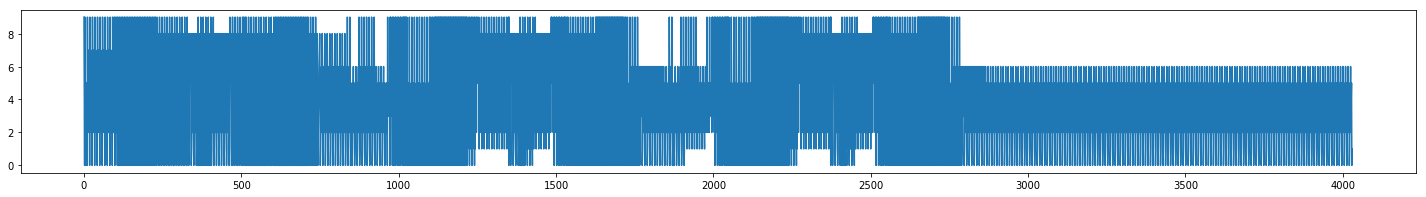

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,3))

plt.plot(y_pred)
plt.show()

In [16]:
YY['labeld']=y_pred
YY

,time,training,labeld
1,1559046842254,0,9
2,1559046843254,0,5
3,1559046844254,0,0
4,1559046845254,0,9
5,1559046846254,0,5
6,1559046847254,0,0
7,1559046848254,0,5
8,1559046849254,0,3
9,1559046850254,0,4
10,1559046851254,0,5


In [17]:
import numpy as np
import pandas
np.savetxt(fname="mrecresult.csv",fmt="%d\t%d\t%f", delimiter="\t",header="time\tnn\tlabeld", X=YY,comments='')

In [18]:
print('Pretrain time:  ', t1 - t0)
print('Clustering time:', t11 - t10)
#print('Total time:     ', t3 - t0)


Pretrain time:   27.218331813812256
Clustering time: 53.82861876487732
